# Integrate/aggregate signals across spatial layers

In this notebook, we will describe some usage principles for the *aggregate* method.

Let's first import some useful libraries and create some dummy data to show the example.

In [122]:
import spatialdata_plot
from spatialdata.datasets import blobs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [123]:
sdata = blobs()
sdata

SpatialData object with:
├── Images
│     └── 'blobs_image': SpatialImage[cyx] (3, 512, 512)
├── Labels
│     └── 'blobs_labels': SpatialImage[yx] (512, 512)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     └── 'blobs_shapes': GeoDataFrame shape: (5, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 26 × 3
    obs: 'region', 'instance_id'
    uns: 'spatialdata_attrs': AnnData (26, 3)
with coordinate systems:
▸ 'global', with elements:
        blobs_image (Images), blobs_labels (Labels), blobs_points (Points), blobs_shapes (Shapes)

We can do various type of aggregations:
- aggregate *images* by *labels*
- aggregate *points* by *shapes*
- aggregate *shapes* by *shapes*

`SpatialData` provides two ways to perform aggregation operations:
- as a class method, in {meth}`spatialdata.SpatialData.aggregate`, which returns a {class}`spatialdata.SpatialData` object.
- as a function {func}`spatialdata.aggregate`, which returns an anndata object.

Let's start with aggregation of *images* by *labels*. This can be achieved with one line of code:

In [124]:
sdata_im = sdata.aggregate(sdata.images["blobs_image"], by="blobs_labels")

/Users/giovanni.palla/Projects/spatialdata/src/spatialdata/_core/spatialdata.py:278: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(adata, region=by, region_key=region_key, instance_key=instance_key)


As default, the aggregation function is `mean`. We can inspect the `AnnData` object to confirm that the operation results in retrieving the mean intensity of each image channel within the boundaries of the labels.
We can also visualize the results with `spatialdata-plot`. By overlaying the labels with the channel where we performed aggregation, we can better appreciate the results. Labels that overlap with high intensity of the channels have indeed a higher mean intensity.

The features of the new table are the following:

In [125]:
sdata_im.table.var_names

Index(['channel_0_mean', 'channel_1_mean', 'channel_2_mean'], dtype='object')

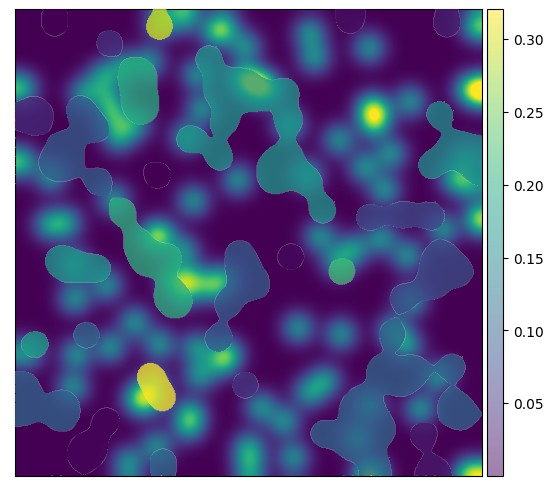

In [126]:
sdata_im.pl.render_images(channel=1).pl.render_labels(color="channel_1_mean", alpha=0.5).pl.show()

We can also aggregate points by shapes. For example, let's count the number of points that overlap each shape.


In [127]:
sdata_shapes = sdata.aggregate(sdata.points["blobs_points"], by="blobs_shapes", id_key="genes", agg_func="count")
sdata_shapes

/Users/giovanni.palla/Projects/anndata/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/giovanni.palla/Projects/spatialdata/src/spatialdata/_core/spatialdata.py:278: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(adata, region=by, region_key=region_key, instance_key=instance_key)


SpatialData object with:
├── Points
│     └── 'points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     └── 'blobs_shapes': GeoDataFrame shape: (4, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4 × 2
    obs: 'instance_id', 'region'
    uns: 'spatialdata_attrs': AnnData (4, 2)
with coordinate systems:
▸ 'global', with elements:
        points (Points), blobs_shapes (Shapes)

/Users/giovanni.palla/Projects/anndata/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/giovanni.palla/Projects/spatialdata-plot/src/spatialdata_plot/pl/render.py:246: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(


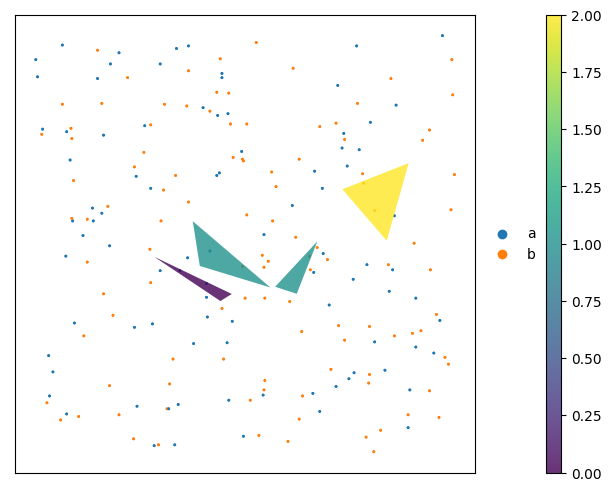

In [130]:
sdata_shapes.pl.render_points(color="genes").pl.render_shapes(color="b", alpha=0.8).pl.show()

The colormap represents the number of counts for the selected variable (gene "b"). The rightmost polygon has correctly a value of 2, as there are 2 transcripts (points) of type "b" overlapping the polygon area.
Beside the method, there is also the functional api {func}`spatialdata.aggregate` which returns an `AnnData` instead of a `SpatialData` object.